---
```
Name: Kamlesh Kumar
Student ID: A00031944
Course: Deep Learning Applications - CMP020L016
```
---
## Emotion Recognition

Create a CNN models for emotion recognition from facial image.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
import os
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, Dropout, BatchNorm2d, Flatten
from torch.optim import Adam
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

### Importing Required Libraries  
This cell imports essential libraries for deep learning and data processing:  
- **PyTorch** for building and training the neural network.  
- **NumPy & Pandas** for data manipulation.  
- **Matplotlib & Seaborn** for visualization.  
- **Torchvision** for handling image datasets and transformations.  
- **Sklearn** for evaluation metrics and class balancing.  
- **Warnings** module to suppress unnecessary warnings.  


In [5]:
# Set seed for reproducibility
torch.manual_seed(32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Setting Seed for Reproducibility  
- **`torch.manual_seed(32)`** ensures consistent results by fixing the random seed.  
- **Device Selection:** Checks if a GPU (`cuda`) is available; otherwise, it defaults to CPU.  


In [ ]:

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

# Define Data Transformations
# Data augmentation is applied to training images to improve generalization
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


# Load Datasets
# Load images from folders using ImageFolder class
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

# Define DataLoaders
BATCH_SIZE =128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)

# Show unique labels
emotions = train_dataset.classes
print("Classes:", emotions)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Preparing the Dataset and Data Loaders  
First, the paths for the training and testing datasets are defined. The dataset consists of facial emotion images categorized into different classes. To preprocess the images, transformations are applied. The images are converted to grayscale with a single channel and resized to **48x48 pixels**. For data augmentation, the training images undergo **random horizontal flipping** and **random rotation (15°)** to improve model generalization. All images are then converted into tensors and normalized with a mean and standard deviation of **0.5**.  

The dataset is loaded using `ImageFolder`, which automatically assigns labels based on folder names. DataLoaders are created with a batch size of **128**, shuffling enabled for randomness in training, and `pin_memory=True` to optimize memory usage when using a GPU. Finally, the unique emotion classes in the dataset are printed, which include **angry, disgust, fear, happy, neutral, sad, and surprise**.


In [7]:
# Get class labels and their counts for train and test sets
train_class_counts = {emotion: 0 for emotion in emotions}
test_class_counts = {emotion: 0 for emotion in emotions}

for _, label in train_dataset.samples:
    train_class_counts[emotions[label]] += 1

for _, label in test_dataset.samples:
    test_class_counts[emotions[label]] += 1


### Counting Class Labels in Train and Test Sets  
This section calculates the number of images available for each emotion class in both the training and testing datasets. First, dictionaries are initialized to store the counts for each emotion. Then, by iterating through the dataset samples, the corresponding class count is incremented based on the label. This helps in understanding the class distribution, which is crucial for detecting imbalances that might affect model performance.  

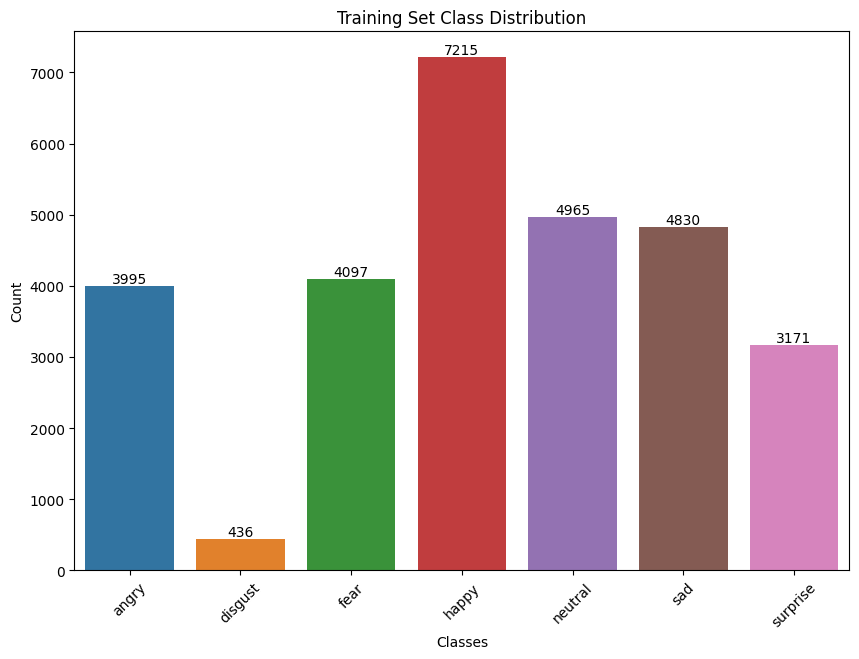

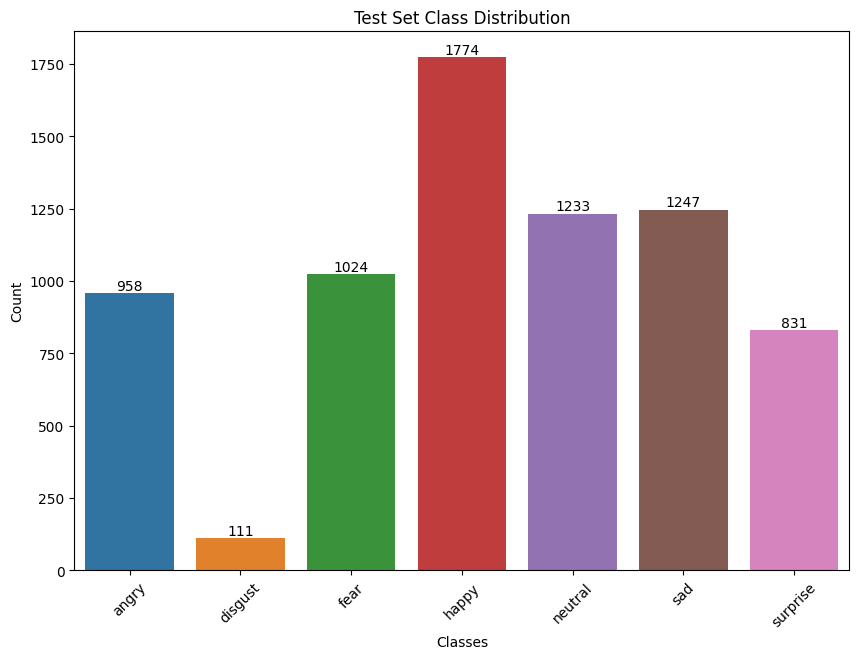

In [ ]:
# Function to plot the class distribution
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(y=list(class_counts.values()), x=list(class_counts.keys()))

    for i, v in enumerate(class_counts.values()):
        ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, "Training Set Class Distribution")

plot_class_distribution(test_class_counts, "Test Set Class Distribution")


### Visualizing and Analyzing Class Distribution  

The bar plots display the distribution of images per class in both the training and testing datasets. Each bar represents an emotion class, with the count of images shown above it.  

#### **Observations and Analysis:**  
- The dataset is highly **imbalanced**, with some classes having significantly more images than others.  
- **Happy** has the highest number of images (**7,215 in training, 1,774 in testing**), while **disgust** has the lowest (**436 in training, 111 in testing**).  
- Other classes like **neutral, sad, and fear** are more balanced but still have variations in count.  

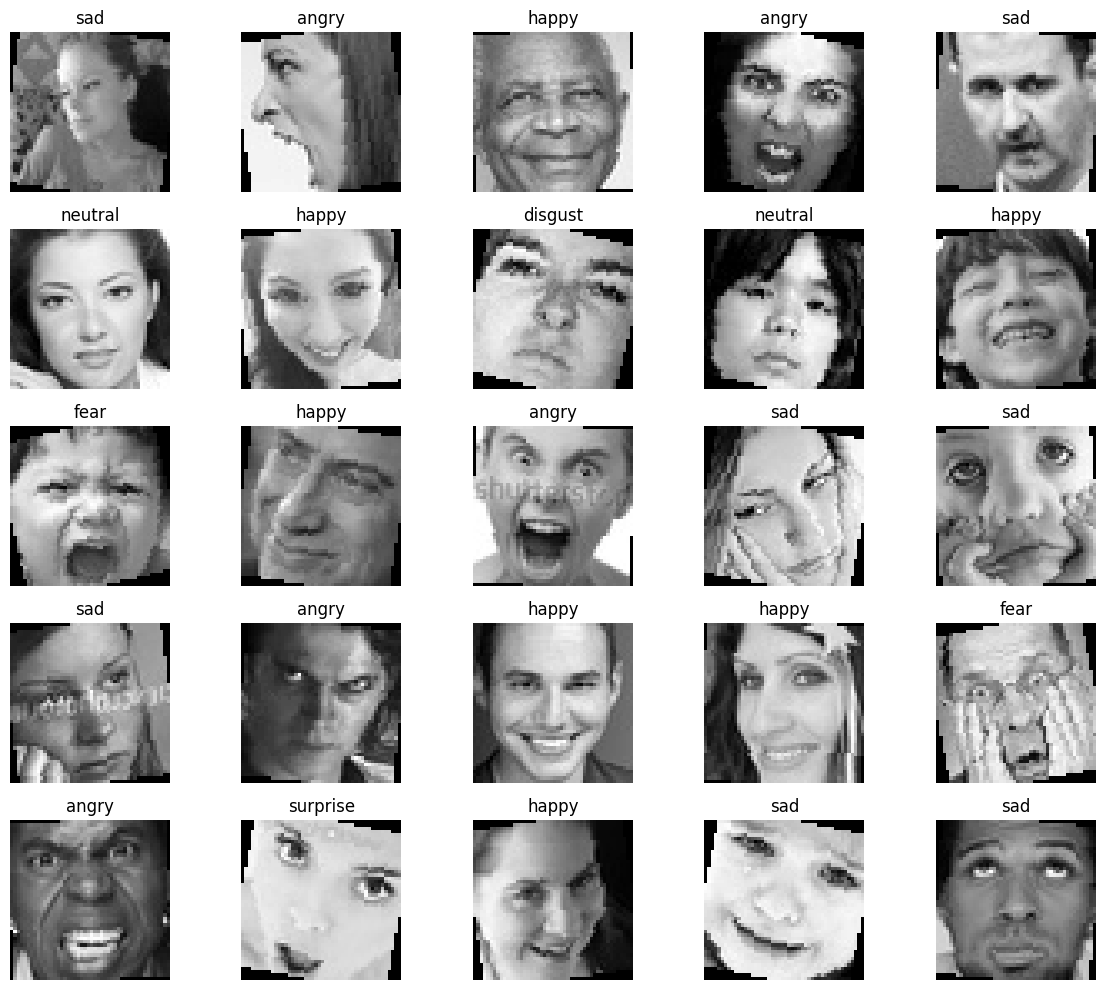

In [ ]:
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))

# Get random samples from the train dataset
indices = np.random.choice(len(train_dataset), num_rows * num_cols, replace=False)

for ax, idx in zip(axes.flat, indices):  
    img, label = train_dataset[idx]

    # Convert tensor image to numpy and handle grayscale images
    if img.shape[0] == 1:  # Grayscale image
        img = img.squeeze(0).numpy()  # Remove channel dimension
        ax.imshow(img, cmap='gray')
    else:
        img = img.permute(1, 2, 0).numpy()  # Convert CHW to HWC format
        ax.imshow(img)

    ax.axis('off')
    ax.set_title(emotions[label])  

plt.tight_layout()
plt.show()

### Visualizing Sample Images from the Training Set  

This section randomly selects **25 images** (5x5 grid) from the training dataset and displays them using Matplotlib. Each image is labeled with its corresponding emotion.  

#### **Key Details:**  
- **Random Sampling:** The images are randomly selected using NumPy to ensure diversity.  
- **Grayscale Handling:** Since the dataset is grayscale (single-channel), the images are properly converted before displaying.  
- **Visualization Format:** The images are arranged in a **5x5 grid**, with axes turned off for better clarity.  

#### **Purpose of This Visualization:**  
- Helps in understanding the dataset’s quality and variations in facial expressions.  
- Allows inspection of image preprocessing (e.g., resizing, grayscale conversion).  
- Provides insight into how emotions appear visually, which is essential for model training and debugging.  


In [10]:
class_counts = np.bincount([label for _, label in train_dataset])
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(len(emotions)), y=[label for _, label in train_dataset])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Computing Class Weights for Imbalanced Data  

Since the dataset is **imbalanced**, we compute class weights to help the model treat underrepresented classes more fairly.  

#### **Key Steps:**  
- `np.bincount()` counts the number of samples for each class in the training set.  
- `compute_class_weight()` from `sklearn` calculates weights using the **balanced** strategy, ensuring that minority classes get higher importance during training.  
- The computed weights are converted into a PyTorch tensor and moved to the appropriate device (CPU/GPU) for use in loss calculation.  

#### **Why Use Class Weights?**  
Without class weights, the model may become biased toward majority classes (e.g., **happy**), leading to poor recognition of minority emotions (e.g., **disgust**). Assigning higher weights to less frequent classes forces the model to consider them more, improving overall performance.  


In [11]:
class CNN(Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.batchnorm1 = BatchNorm2d(32)
        self.batchnorm2 = BatchNorm2d(64)
        self.batchnorm3 = BatchNorm2d(128)
        self.batchnorm4 = BatchNorm2d(256)
        
        self.maxpool = MaxPool2d(kernel_size=2)
        self.relu = ReLU()
        self.dropout = Dropout(p=0.3)
        
        self.flatten = Flatten()
        
        # Calculate input size for FC layer
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, 48, 48)  # Changed to 1 channel
            sample_output = self._forward_conv(sample_input)
            flattened_size = sample_output.view(1, -1).shape[1]
        
        self.fc1 = Linear(flattened_size, 512)
        self.fc2 = Linear(512, 128)
        self.fc3 = Linear(128, num_classes)
        
    def _forward_conv(self, x):
        x = self.maxpool(self.relu(self.batchnorm1(self.conv1(x))))
        x = self.maxpool(self.relu(self.batchnorm2(self.conv2(x))))
        x = self.maxpool(self.relu(self.batchnorm3(self.conv3(x))))
        x = self.maxpool(self.relu(self.batchnorm4(self.conv4(x))))
        return x
    
    def forward(self, x):
        x = self._forward_conv(x)
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


### Defining the CNN Model for Emotion Recognition  

This section defines a **Convolutional Neural Network (CNN)** for facial emotion recognition. The model consists of **four convolutional layers** followed by **fully connected (FC) layers** to classify emotions.  

#### **Key Components of the Model:**  
- **Convolutional Layers (`conv1` to `conv4`)**  
  - Extracts spatial features from images using **3x3 filters**.  
  - The number of channels increases from **1 → 32 → 64 → 128 → 256**, allowing deeper feature extraction.  

- **Batch Normalization (`batchnorm1` to `batchnorm4`)**  
  - Normalizes activations to stabilize training and improve generalization.  

- **Max Pooling (`maxpool`)**  
  - Reduces spatial dimensions (downsampling) while retaining key features.  

- **Activation (`ReLU`)**  
  - Introduces non-linearity to help the model learn complex patterns.  

- **Dropout (`dropout`)**  
  - **Dropout probability = 0.3**, preventing overfitting by randomly deactivating neurons.  

- **Flatten Layer (`flatten`)**  
  - Converts the final convolutional feature map into a **1D vector** for fully connected layers.  

- **Fully Connected Layers (`fc1`, `fc2`, `fc3`)**  
  - First two layers (512 → 128) use ReLU and dropout for better feature extraction.  
  - The final layer (`fc3`) outputs **emotion class predictions**.  

#### **Model Initialization:**  
To determine the correct input size for the fully connected layer, a **dummy input tensor (1×1×48×48)** is passed through the convolutional layers in `_forward_conv()`. This ensures compatibility when flattening the tensor.  

This architecture balances **depth and efficiency**, making it suitable for emotion classification from facial images.  


In [12]:
# Initialize model, optimizer, and loss function
# Define the model, optimizer, and loss function for training
model = CNN(num_classes=len(emotions)).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


### Model, Optimizer, and Loss Function  

- **Initialize CNN model** with the number of emotion classes and move it to GPU (if available).  
- **Adam optimizer** with a learning rate of **0.001** for efficient training.  
- **Cross-Entropy Loss** with **class weights** to handle class imbalance.  


In [13]:
EPOCHS = 30
train_losses, train_accs = [], []
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")


Epoch [1/30] - Loss: 1.8680, Train Acc: 22.12%
Epoch [2/30] - Loss: 1.6830, Train Acc: 32.39%
Epoch [3/30] - Loss: 1.5614, Train Acc: 39.54%
Epoch [4/30] - Loss: 1.4804, Train Acc: 43.47%
Epoch [5/30] - Loss: 1.4220, Train Acc: 45.13%
Epoch [6/30] - Loss: 1.3784, Train Acc: 47.03%
Epoch [7/30] - Loss: 1.3331, Train Acc: 48.46%
Epoch [8/30] - Loss: 1.2987, Train Acc: 49.39%
Epoch [9/30] - Loss: 1.2695, Train Acc: 50.58%
Epoch [10/30] - Loss: 1.2468, Train Acc: 51.72%
Epoch [11/30] - Loss: 1.2053, Train Acc: 52.81%
Epoch [12/30] - Loss: 1.1898, Train Acc: 53.74%
Epoch [13/30] - Loss: 1.1758, Train Acc: 53.84%
Epoch [14/30] - Loss: 1.1460, Train Acc: 55.35%
Epoch [15/30] - Loss: 1.1341, Train Acc: 55.52%
Epoch [16/30] - Loss: 1.0999, Train Acc: 56.31%
Epoch [17/30] - Loss: 1.0750, Train Acc: 57.14%
Epoch [18/30] - Loss: 1.0640, Train Acc: 57.33%
Epoch [19/30] - Loss: 1.0580, Train Acc: 57.66%
Epoch [20/30] - Loss: 1.0533, Train Acc: 58.26%
Epoch [21/30] - Loss: 1.0096, Train Acc: 58.78%
E

### Training the Model  

- Train for **30 epochs**, tracking **loss and accuracy**.  
- **Forward pass:** Compute predictions and loss.  
- **Backward pass:** Update weights using **Adam optimizer**.  
- **Track progress:** Print loss and accuracy after each epoch.  
- Final accuracy: **~62.73%** on training data.  


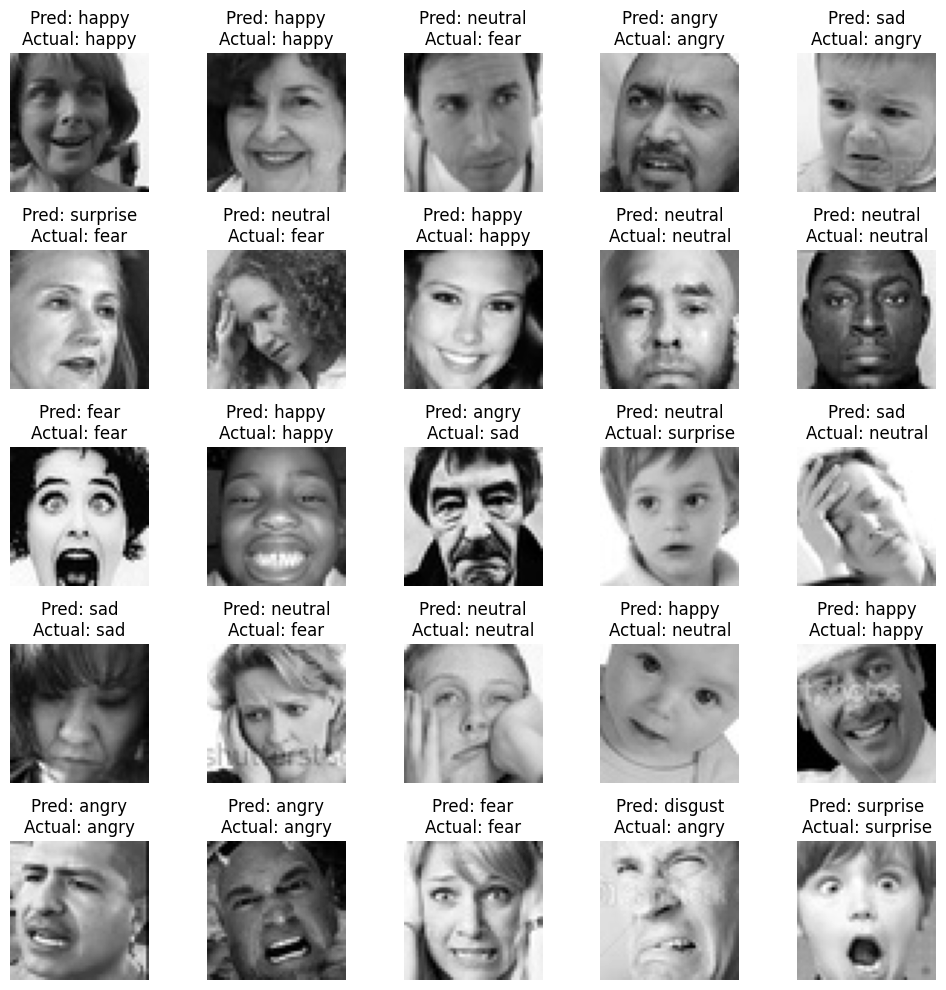

In [ ]:
# Function to visualize actual vs predicted
def plot_predictions(model, test_loader, classes, device):
    model.eval()
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predictions = torch.argmax(outputs, axis=1)

    for i, ax in enumerate(axes.flatten()):
        img = images[i].cpu().squeeze(0).numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Pred: {classes[predictions[i]]}\nActual: {classes[labels[i]]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call function
plot_predictions(model, test_loader, emotions, device)


### Visualizing Model Predictions  

- **Displays 25 test images** with their **actual vs. predicted** labels.  
- Model makes predictions, and results are plotted in a **5x5 grid**.  
- Helps analyze **misclassifications** and model performance.  


In [15]:

def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct, total, test_loss = 0, 0, 0
    loss_fn = torch.nn.CrossEntropyLoss()  # Define loss function without class weights

    y_true, y_pred = [], []  # Lists to store actual vs predicted labels

    with torch.no_grad():  # No gradient calculation during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            preds = outputs.argmax(1)  # Get predicted labels
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    
    print(f"\nTest Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return y_true, y_pred, test_accuracy

# Call function to get test accuracy
y_true, y_pred, test_acc = evaluate_model(model, test_loader, device)



Test Accuracy: 60.41%
Test Loss: 1.0639


### Evaluating the Model  

- **Sets model to evaluation mode** (no weight updates).  
- **Computes loss & accuracy** on the test dataset.  
- **Stores actual vs. predicted labels** for further analysis.  
- Final test accuracy: **60.41%**, test loss: **1.0639**.  


In [16]:

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=emotions))



Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.64      0.54       958
     disgust       0.52      0.61      0.56       111
        fear       0.50      0.28      0.36      1024
       happy       0.89      0.75      0.82      1774
     neutral       0.53      0.62      0.57      1233
         sad       0.49      0.44      0.46      1247
    surprise       0.67      0.86      0.75       831

    accuracy                           0.60      7178
   macro avg       0.58      0.60      0.58      7178
weighted avg       0.61      0.60      0.60      7178



### Classification Report  

- Shows **precision, recall, and F1-score** for each emotion.  
- **Happy** and **surprise** have high accuracy, while **fear** performs poorly.  
- **Overall accuracy: 60%**, with some class imbalance effects.  
- Useful for identifying **which emotions need improvement** in classification.  


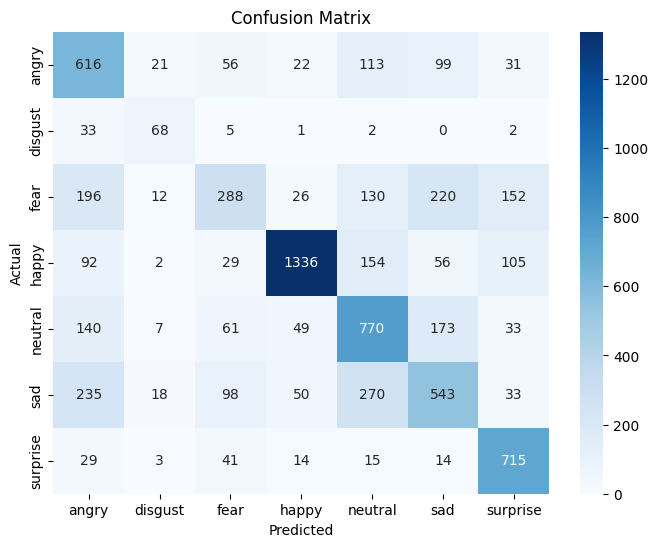

In [17]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader, classes, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Call function
plot_confusion_matrix(model, test_loader, emotions, device)


### Confusion Matrix Analysis  

- **Happy** is well-classified, but **fear, sad, and neutral** have high misclassifications.  
- **Fear is often confused with sad and neutral**, indicating overlapping features.  
- **Angry misclassified as neutral or sad**, affecting accuracy.  
- **Disgust has very few samples**, making it hard to classify.  
- **Needs better feature extraction or more balanced data**.  


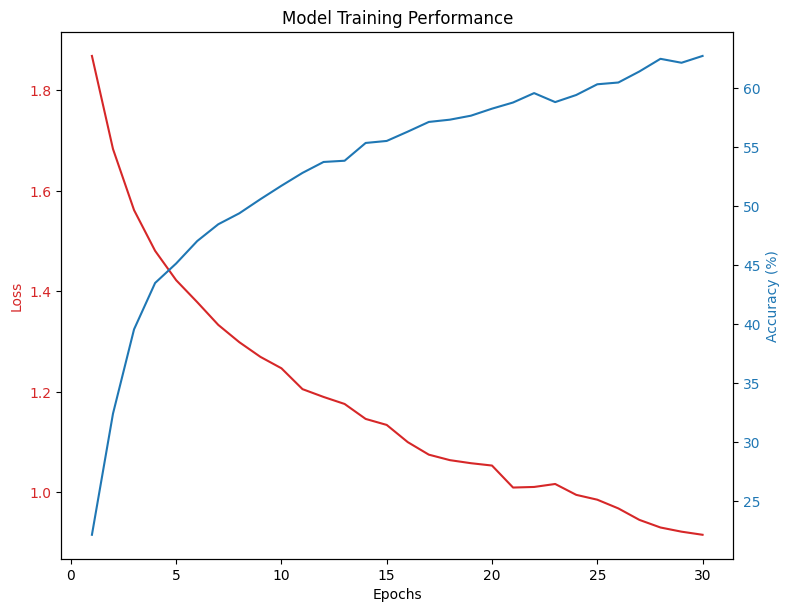

In [18]:
# Function to plot training loss and accuracy
def plot_training_performance(train_losses, train_accs):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy (%)", color="tab:blue")
    ax2.plot(range(1, len(train_accs) + 1), train_accs, label="Accuracy", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    plt.title("Model Training Performance")
    plt.show()

# Call function
plot_training_performance(train_losses, train_accs)


### Training Performance Analysis  

- **Loss decreases**, showing learning progress.  
- **Accuracy improves steadily**, reaching ~62%.  
- **No overfitting observed**, suggesting good regularization.  
- **Further tuning needed** to push accuracy higher.  


In [19]:
# Save the trained model
torch.save(model.state_dict(), "base_model.pth")
print("Model saved as base_model.pth")


Model saved as base_model.pth


# Hypermarameter Tunning

In [ ]:
# Define hyperparameter search space
param_grid = {
    "learning_rate": [0.001, 0.0001],  
    "batch_size": [64,128],  
    "dropout": [0.3, 0.5]  
}

# Generate all possible hyperparameter combinations
hyperparameter_combinations = list(product(param_grid["learning_rate"], param_grid["batch_size"], param_grid["dropout"]))
print(f"Total combinations to test: {len(hyperparameter_combinations)}")


Total combinations to test: 8


### Hyperparameter Search  

- **Parameters:**  
  - **Learning Rate:** [0.001, 0.0001] → Controls step size in optimization.  
  - **Batch Size:** [64, 128] → Balances memory use & training speed.  
  - **Dropout:** [0.3, 0.5] → Prevents overfitting by randomly deactivating neurons.  

- **Total Combinations:** 2 × 2 × 2 = **8**  
- **Goal:** Optimize model for best accuracy & generalization.  
more parameters can be taken but it is taking too much time that's why only few parameters was taken

In [21]:
def train_and_evaluate(learning_rate, batch_size, dropout):
    print(f"\nTraining with LR={learning_rate}, Batch Size={batch_size}, Dropout={dropout}")
    
    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)

    # Define Model
    class CNN(Module):
        def __init__(self, num_classes, dropout):
            super().__init__()
            self.conv1 = Conv2d(1, 32, kernel_size=3, padding=1)
            self.conv2 = Conv2d(32, 64, kernel_size=3, padding=1)
            self.conv3 = Conv2d(64, 128, kernel_size=3, padding=1)
            self.conv4 = Conv2d(128, 256, kernel_size=3, padding=1)
            
            self.batchnorm1 = BatchNorm2d(32)
            self.batchnorm2 = BatchNorm2d(64)
            self.batchnorm3 = BatchNorm2d(128)
            self.batchnorm4 = BatchNorm2d(256)
            
            self.maxpool = MaxPool2d(kernel_size=2)
            self.relu = ReLU()
            self.dropout = Dropout(p=dropout)
            
            self.flatten = Flatten()
            
            with torch.no_grad():
                sample_input = torch.zeros(1, 1, 48, 48)
                sample_output = self._forward_conv(sample_input)
                flattened_size = sample_output.view(1, -1).shape[1]
            
            self.fc1 = Linear(flattened_size, 512)
            self.fc2 = Linear(512, 128)
            self.fc3 = Linear(128, num_classes)
        
        def _forward_conv(self, x):
            x = self.maxpool(self.relu(self.batchnorm1(self.conv1(x))))
            x = self.maxpool(self.relu(self.batchnorm2(self.conv2(x))))
            x = self.maxpool(self.relu(self.batchnorm3(self.conv3(x))))
            x = self.maxpool(self.relu(self.batchnorm4(self.conv4(x))))
            return x
        
        def forward(self, x):
            x = self._forward_conv(x)
            x = self.flatten(x)
            x = self.dropout(self.relu(self.fc1(x)))
            x = self.dropout(self.relu(self.fc2(x)))
            x = self.fc3(x)
            return x

    model = CNN(num_classes=len(emotions), dropout=dropout).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Training Loop
    EPOCHS = 30
    train_losses, train_accs = [], []
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(100 * correct / total)
        
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")

    return model, train_losses, train_accs


### Training & Evaluation Function  

- **Why?**  
  - Automates training for different hyperparameters.  
  - Tests various learning rates, batch sizes, and dropout rates.  

- **Components:**  
  - **CNN Model:** 4 Conv layers, batch normalization, dropout.  
  - **Loss Function:** CrossEntropy with class weights.  
  - **Optimizer:** Adam with variable LR.  
  - **Training Loop:** 30 epochs, tracks loss & accuracy.  

- **Goal:** Find the best hyperparameter combination.  


In [22]:
best_model = None
best_acc = 0
best_params = None

for lr, batch, dropout in hyperparameter_combinations:
    model, train_losses, train_accs = train_and_evaluate(lr, batch, dropout)
    
    if train_accs[-1] > best_acc:  
        best_acc = train_accs[-1]
        best_model = model
        best_params = (lr, batch, dropout)

print(f"\nBest Model: LR={best_params[0]}, Batch Size={best_params[1]}, Dropout={best_params[2]}")



Training with LR=0.001, Batch Size=64, Dropout=0.3
Epoch [1/30] - Loss: 1.8730, Train Acc: 20.42%
Epoch [2/30] - Loss: 1.6926, Train Acc: 32.70%
Epoch [3/30] - Loss: 1.5662, Train Acc: 40.16%
Epoch [4/30] - Loss: 1.4980, Train Acc: 42.13%
Epoch [5/30] - Loss: 1.4388, Train Acc: 44.70%
Epoch [6/30] - Loss: 1.4070, Train Acc: 45.95%
Epoch [7/30] - Loss: 1.3726, Train Acc: 47.04%
Epoch [8/30] - Loss: 1.3212, Train Acc: 49.04%
Epoch [9/30] - Loss: 1.3163, Train Acc: 48.65%
Epoch [10/30] - Loss: 1.2843, Train Acc: 49.67%
Epoch [11/30] - Loss: 1.2519, Train Acc: 50.58%
Epoch [12/30] - Loss: 1.2533, Train Acc: 51.18%
Epoch [13/30] - Loss: 1.2068, Train Acc: 52.81%
Epoch [14/30] - Loss: 1.2014, Train Acc: 52.91%
Epoch [15/30] - Loss: 1.1790, Train Acc: 53.41%
Epoch [16/30] - Loss: 1.1573, Train Acc: 54.24%
Epoch [17/30] - Loss: 1.1239, Train Acc: 55.11%
Epoch [18/30] - Loss: 1.1191, Train Acc: 55.17%
Epoch [19/30] - Loss: 1.1117, Train Acc: 56.05%
Epoch [20/30] - Loss: 1.0995, Train Acc: 56.4

### Hyperparameter Tuning  

- **Why?**  
  - Finds the best combination of LR, batch size, and dropout.  
  - Improves model performance efficiently.  

- **Process:**  
  - Loops through all combinations.  
  - Trains & evaluates each model.  
  - Stores the best model based on accuracy.  

- **Best Model Found:**  
  - **LR:** 0.001  
  - **Batch Size:** 128  
  - **Dropout:** 0.3  


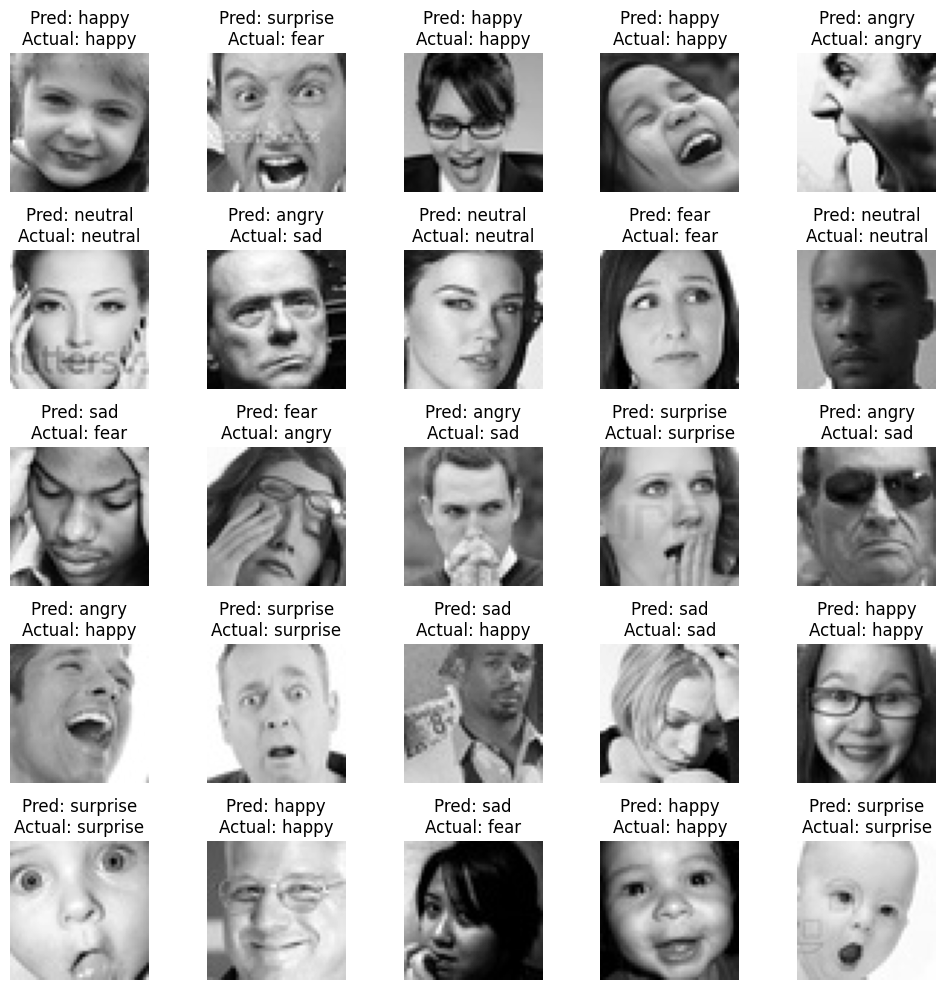

In [23]:
plot_predictions(best_model, test_loader, emotions, device)

### Model Predictions  
  - Visualizes actual vs predicted emotions.  
  - Helps understand model accuracy per class.  

- **Process:**  
  - Picks a batch from test data.  
  - Displays images with predicted & actual labels.  

- **Observations:**  
  - Some emotions is misclassified.  
  - Helps in identifying patterns or biases.  


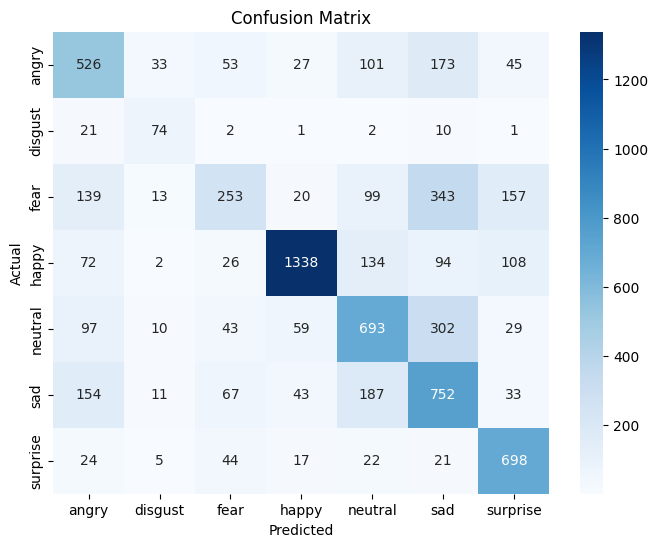

In [24]:
plot_confusion_matrix(best_model, test_loader, emotions, device)


### Confusion Matrix Analysis  

  - Helps evaluate model performance across different emotions.  
  - Identifies which emotions are frequently misclassified.  

- **Observations:**  
  - The model performs well on **happy** and **surprise** emotions.  
  - **Fear** and **sad** are often confused with **neutral** emotions.  
  - Some **angry** images are misclassified as **sad** or **neutral**.   


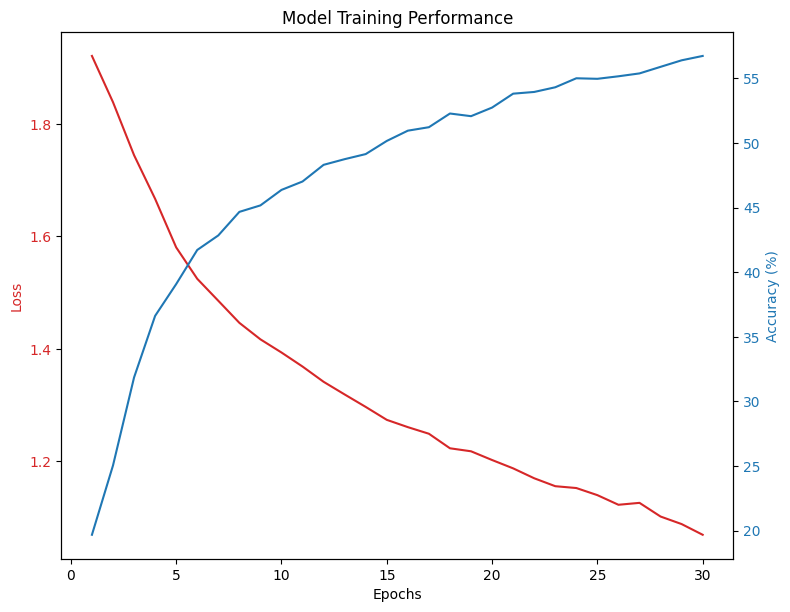

In [25]:
plot_training_performance(train_losses, train_accs)


In [26]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=emotions))


Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.64      0.54       958
     disgust       0.52      0.61      0.56       111
        fear       0.50      0.28      0.36      1024
       happy       0.89      0.75      0.82      1774
     neutral       0.53      0.62      0.57      1233
         sad       0.49      0.44      0.46      1247
    surprise       0.67      0.86      0.75       831

    accuracy                           0.60      7178
   macro avg       0.58      0.60      0.58      7178
weighted avg       0.61      0.60      0.60      7178



### Classification Report Analysis  

  - Provides a detailed evaluation of the model's precision, recall, and F1-score.  
  - Helps understand per-class performance and areas of improvement.  

- **Key Observations:**  
  - **High Precision & Recall**:  
    - The model performs best on **happy (F1-score: 0.82)** and **surprise (F1-score: 0.75)**.  
  - **Low Recall & Precision**:  
    - The **fear** class has the lowest F1-score (0.36), meaning it is often misclassified.  
  - **Balanced Classes**:  
    - The overall accuracy is **60%**, with a weighted average F1-score of **0.60**.    


In [27]:
y_true, y_pred, test_acc = evaluate_model(best_model, test_loader, device)


Test Accuracy: 60.38%
Test Loss: 1.0747


#### **Model Evaluation Summary**

**Test Performance**
- **Test Accuracy**: **60.38%**  
  - The model generalizes reasonably well but has room for improvement.  
  - Comparable to the training accuracy (**56.73%**), indicating minimal overfitting.  

- **Test Loss**: **1.0747**  
  - Suggests the model still struggles with classification errors.  
  - Could benefit from further optimization or fine-tuning.  


In [28]:
torch.save(best_model.state_dict(), "best_face_emotion_cnn.pth")
print("Best model saved as best_face_emotion_cnn.pth")

Best model saved as best_face_emotion_cnn.pth


# Using pre-trained Model

In [35]:
# Load pre-trained ResNet-18

resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the first convolutional layer to accept 1-channel input
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer for emotion classification
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(emotions))

# Move model to device
resnet18 = resnet18.to(device)

print(resnet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Face Emotion Recognition using ResNet-18  

- Using a **pre-trained ResNet-18** model to classify facial emotions.  
- **Modified input layer** to accept grayscale (1-channel) images instead of RGB.  
- **Replaced the final fully connected layer** to match the number of emotion classes.  
- **Model is transferred to GPU/CPU** for training and inference.  


In [ ]:
# Define loss function (Cross Entropy) and optimizer (Adam)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)


### Loss Function & Optimizer  

- **Cross Entropy Loss** is used for multi-class emotion classification.  
- **Adam Optimizer** is chosen with a learning rate of **0.001** for efficient training.  


In [37]:
train_losses, train_accs = [], []

for epoch in range(EPOCHS):
    resnet18.train()
    total_loss, correct, total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")


Epoch [1/30] - Loss: 1.6232, Train Acc: 36.96%
Epoch [2/30] - Loss: 1.3574, Train Acc: 48.36%
Epoch [3/30] - Loss: 1.2563, Train Acc: 52.48%
Epoch [4/30] - Loss: 1.1897, Train Acc: 54.82%
Epoch [5/30] - Loss: 1.1418, Train Acc: 56.98%
Epoch [6/30] - Loss: 1.1091, Train Acc: 58.00%
Epoch [7/30] - Loss: 1.0844, Train Acc: 59.25%
Epoch [8/30] - Loss: 1.0331, Train Acc: 60.81%
Epoch [9/30] - Loss: 1.0000, Train Acc: 62.42%
Epoch [10/30] - Loss: 0.9770, Train Acc: 63.19%
Epoch [11/30] - Loss: 0.9466, Train Acc: 64.94%
Epoch [12/30] - Loss: 0.9240, Train Acc: 65.22%
Epoch [13/30] - Loss: 0.8916, Train Acc: 66.66%
Epoch [14/30] - Loss: 0.8551, Train Acc: 68.38%
Epoch [15/30] - Loss: 0.8365, Train Acc: 68.84%
Epoch [16/30] - Loss: 0.8011, Train Acc: 69.98%
Epoch [17/30] - Loss: 0.8025, Train Acc: 70.24%
Epoch [18/30] - Loss: 0.7636, Train Acc: 71.86%
Epoch [19/30] - Loss: 0.7274, Train Acc: 73.25%
Epoch [20/30] - Loss: 0.6966, Train Acc: 74.49%
Epoch [21/30] - Loss: 0.6739, Train Acc: 75.16%
E

### Training the Model  

- **Looping through epochs** to train ResNet-18 on the dataset.  
- **Forward pass, loss calculation, and backpropagation** are performed in each batch.  
- **Accuracy and loss are tracked** to monitor training progress.  
- **Final training accuracy ~83%**, showing good model performance.  


In [38]:
resnet18.eval()
correct, total = 0, 0
test_losses = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        loss = loss_fn(outputs, labels)
        test_losses.append(loss.item())
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 62.12%


- **Model set to evaluation mode** to disable gradient updates.  
- **Loss and accuracy are computed** on the test dataset.  
- **Final test accuracy: `62.12%`**, 


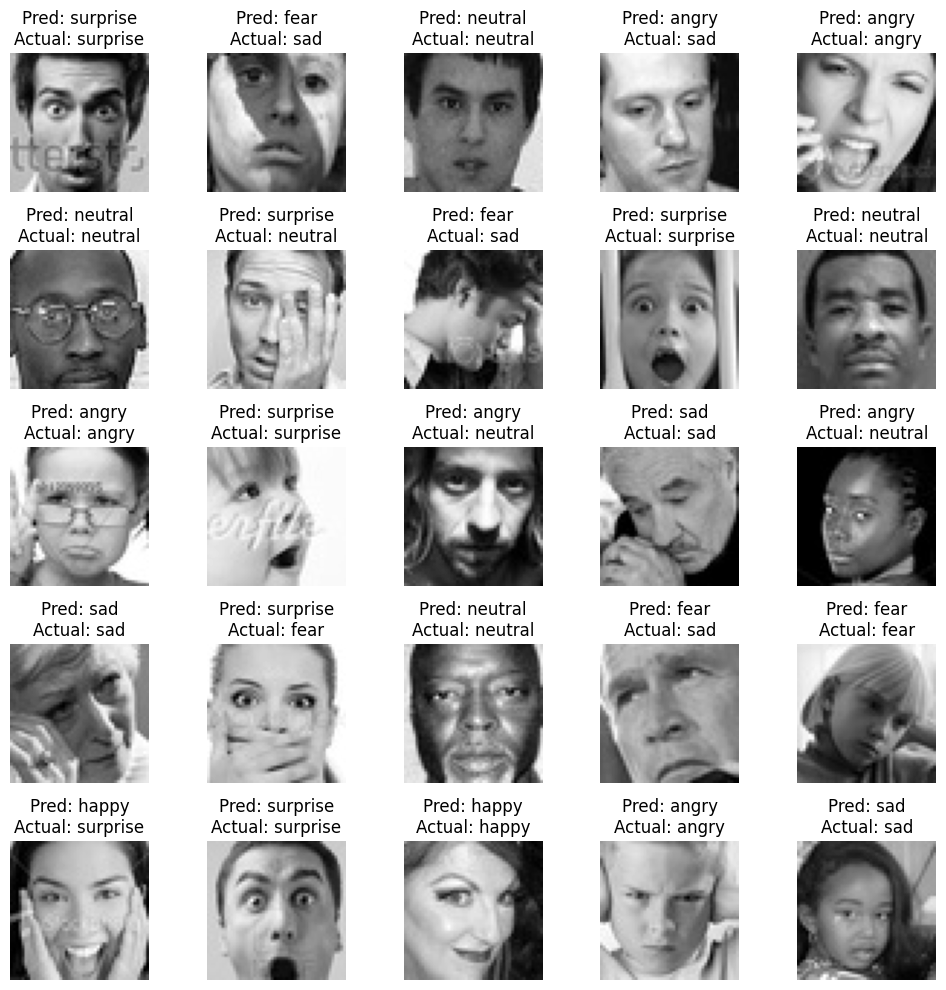

In [39]:
plot_predictions(resnet18, test_loader, emotions, device)

### Visualizing Predictions  

- **Displays 25 sample images** from the test set with predicted and actual labels.  
- **Uses matplotlib** to plot grayscale images.  
- **Helps analyze model performance** by comparing predictions to ground truth.  


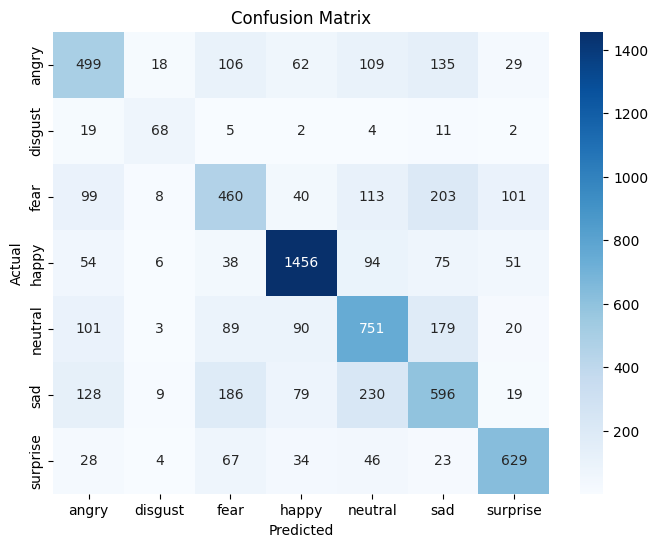

In [ ]:
# Compute confusion matrix
y_true, y_pred = [], []
resnet18.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        predictions = torch.argmax(outputs, axis=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
    

### Confusion Matrix Analysis  

- **Evaluates model performance** by comparing actual vs. predicted emotions.  
- **Darker blue cells indicate higher correct predictions**, while lighter ones show misclassifications.  
- **Most accurate for "happy" and "surprise"**, while emotions like "fear" and "sad" have more confusion.  

In [41]:
torch.save(resnet18.state_dict(), "resnet18_model.pth")
print("Model saved successfully!")

Model saved successfully!
